In [384]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import normalize

#from scipy import stats



#from tqdm import tqdm #timer??
#from prophet import Prophet
#import scipy as sp



In [290]:
data = pd.read_csv('teslas.csv')
#Setting dates to correct format
data[['sold_at', 'created_at']] = data[['sold_at', 'created_at']].apply(pd.to_datetime)
#data['sold_at'] = pd.to_datetime(data['sold_at'])
#data['created_at'] = pd.to_datetime(data['created_at'])

#Creat additional columns of interest
data['days_befor_sale'] = (data['sold_at'] - data['created_at']).dt.days
data['sold_at_week_number'] = data['sold_at'].dt.strftime('%U')

data['v_age'] = data['v_months_since_first_time_registered_date']/12.0
data = data.round({'v_age':2})
data = data.drop(['v_months_since_first_time_registered_date'], axis=1)



#Change from two too one column
#data['v_four_wheel_drive'] = (data['v_front_wheel_drive'] == True) & (data['v_back_wheel_drive'] == True)
data['v_drive_train'] = "Four wheel drive"
data.loc[(data['v_front_wheel_drive'] == False), 'v_drive_train'] = "Rear wheel drive"

data = data.drop(['v_front_wheel_drive', 'v_back_wheel_drive'], axis=1)
data['v_total_maximum_netto_effect'] = (data['v_motor1_maximum_netto_effect'] + data['v_motor2_maximum_netto_effect'])
data['n'] = 1
data.head()

,created_at,sold_at,v_reg_nr,v_model_year_vim,v_make,sales_type,price,kilometers,v_width,v_length,...,v_import_country,v_fuel_type,retailer_count,v_el_range,days_befor_sale,sold_at_week_number,v_age,v_drive_train,v_total_maximum_netto_effect,n
0,2022-09-11,2022-09-15,EL45905,2015.0,MODELS,Privat,330009.0,133595.0,1964.0,4970.0,...,NORGE,Elektrisk,1.0,0.0,4,37,7.33,Four wheel drive,290.0,1
1,2022-09-10,2022-09-15,EV66503,2019.0,MODEL3,Privat,391670.0,42867.0,1850.0,4694.0,...,NORGE,Elektrisk,1.0,560.0,5,37,3.33,Four wheel drive,340.0,1
2,2022-09-07,2022-09-15,EV64926,2019.0,MODEL3,Forhandler,429000.0,55000.0,1850.0,4694.0,...,NORGE,Elektrisk,327.0,560.0,8,37,3.50,Four wheel drive,340.0,1
3,2022-09-10,2022-09-15,EV60868,2019.0,MODEL3,Privat,379670.0,74000.0,1850.0,4694.0,...,NORGE,Elektrisk,1.0,560.0,5,37,3.50,Four wheel drive,340.0,1
4,2022-08-28,2022-09-15,EV96977,2019.0,MODEL3,Privat,400670.0,94000.0,1850.0,4694.0,...,NORGE,Elektrisk,1.0,560.0,18,37,3.00,Four wheel drive,350.0,1


In [291]:
data.describe()

,v_model_year_vim,price,kilometers,v_width,v_length,v_maximum_speed,v_motor1_maximum_effect_per_hour,v_motor2_maximum_effect_per_hour,v_motor1_maximum_netto_effect,v_motor2_maximum_netto_effect,v_weight,v_allowed_total_weight,v_allowed_trailer_weight_without_breaks,retailer_count,v_el_range,days_befor_sale,v_age,v_total_maximum_netto_effect,n
count,7389.000000,7.389000e+03,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.000000,7389.0
mean,2018.344025,4.689403e+05,61595.723508,1921.565300,4858.280417,230.658682,72.736365,68.130464,153.853295,164.521315,2069.707538,2544.187170,342.637705,63.295168,478.177561,24.894438,3.192621,318.374611,1.0
std,2.297614,1.260922e+05,48816.076615,62.220287,154.365208,15.798744,9.580554,33.746203,65.174017,85.541715,204.687422,295.538606,372.447002,128.022135,149.738372,46.893135,2.192102,133.360457,0.0
min,2013.000000,1.800000e+05,0.000000,1850.000000,4694.000000,190.000000,0.000000,0.000000,0.000000,0.000000,1609.000000,2014.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2017.000000,3.950000e+05,24000.000000,1850.000000,4694.000000,217.000000,65.000000,79.000000,150.000000,190.000000,1906.000000,2305.000000,0.000000,1.000000,460.000000,5.000000,1.500000,340.000000,1.0
50%,2019.000000,4.500000e+05,52000.000000,1964.000000,4970.000000,233.000000,69.000000,79.000000,158.000000,193.000000,2081.000000,2590.000000,0.000000,1.000000,507.000000,11.000000,2.920000,366.000000,1.0
75%,2020.000000,5.399000e+05,87089.000000,1964.000000,4979.000000,250.000000,79.000000,88.000000,193.000000,208.000000,2187.000000,2670.000000,750.000000,45.000000,560.000000,24.000000,4.500000,386.000000,1.0
max,2022.000000,1.050000e+06,332000.000000,2000.000000,5052.000000,262.000000,100.000000,96.000000,350.000000,380.000000,2572.000000,3120.000000,750.000000,1122.000000,652.000000,555.000000,9.000000,599.000000,1.0


<AxesSubplot:>

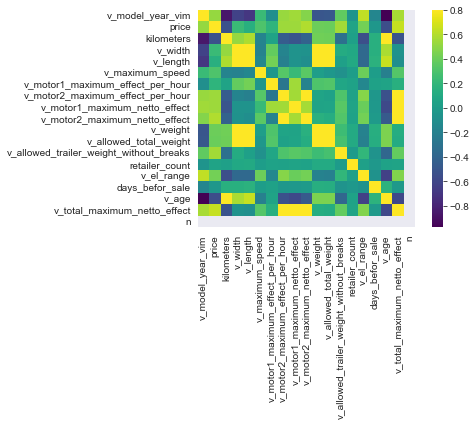

In [292]:
float_data = data.drop(['v_make',
                    'v_drive_train',
                     'sales_type',
                     'v_color',
                     'v_import_country',
                    'v_fuel_type'],
                    axis=1)

sns.heatmap(float_data.corr(), vmax=.8, square=True, cmap='viridis')

In [293]:
#float_columns = data.dtypes[data.dtypes == 'float64'].index
#sns.pairplot(data[float_columns])
#plt.savefig('pair_plot.png')

In [294]:
#Comment out becouse super slow
"""
hue_data = data.drop(['sales_type',
                        'v_front_wheel_drive',
                        'v_back_wheel_drive',
                        'v_color',
                        'v_import_country',
                        'v_fuel_type'],
                       axis=1)
sns.pairplot(hue_data, hue='v_make')
plt.savefig('pair_plot_hue.png')
"""

"\nhue_data = data.drop(['sales_type',\n                        'v_front_wheel_drive',\n                        'v_back_wheel_drive',\n                        'v_color',\n                        'v_import_country',\n                        'v_fuel_type'],\n                       axis=1)\nsns.pairplot(hue_data, hue='v_make')\nplt.savefig('pair_plot_hue.png')\n"

<AxesSubplot:xlabel='kilometers', ylabel='price'>

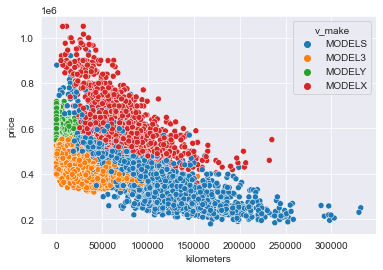

In [295]:
sns.scatterplot(data=data, x='kilometers', y='price', hue='v_make')

<AxesSubplot:xlabel='XXX', ylabel='price'>

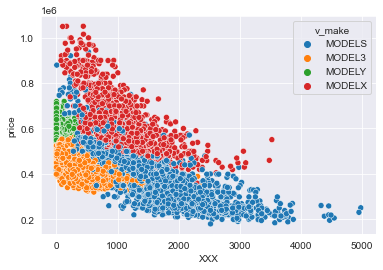

In [296]:
#try to minimze the spred by multiplying featrues
scatter_1 = data.copy()
scatter_1['XXX'] = ((data['v_age']*3 + data['kilometers']*15 + data['v_el_range']/5)/1000.0)
sns.scatterplot(data=scatter_1, x='XXX', y='price', hue='v_make')

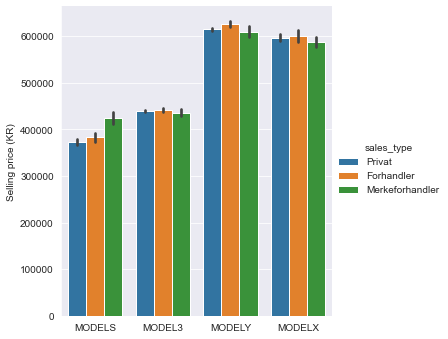

In [297]:
#sns.barplot(data=data, x='price', y='v_make',hue='v_make')
cat_plot = sns.catplot(data=data,
                       kind='bar',
                       x='v_make',
                       y='price',
                       hue='sales_type')
cat_plot.set_axis_labels('', 'Selling price (KR)')


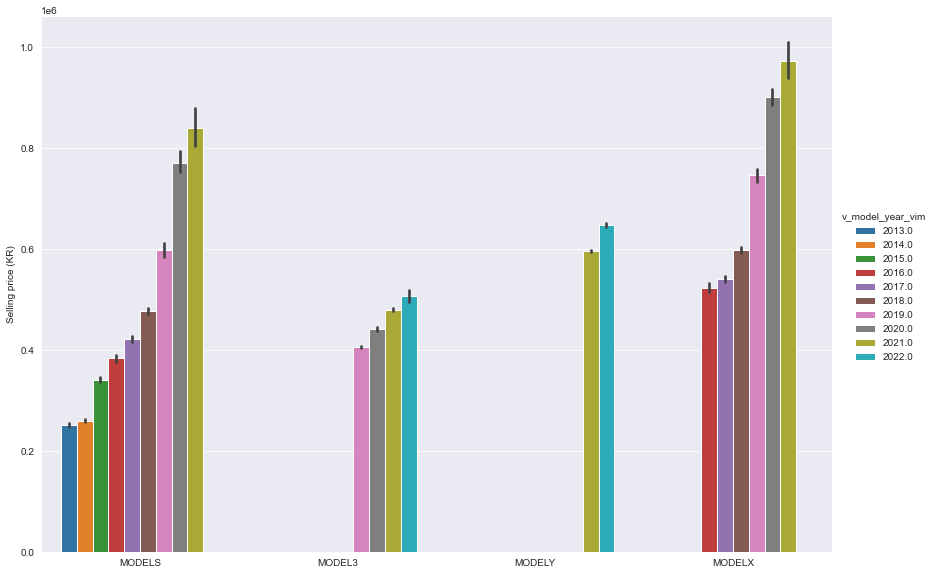

In [298]:
cat_plot = sns.catplot(data=data,
                       kind='bar',
                       x='v_make',
                       y='price',
                       hue='v_model_year_vim',
                       height=8.27, aspect=11.7/8.2)
cat_plot.set_axis_labels('', 'Selling price (KR)')

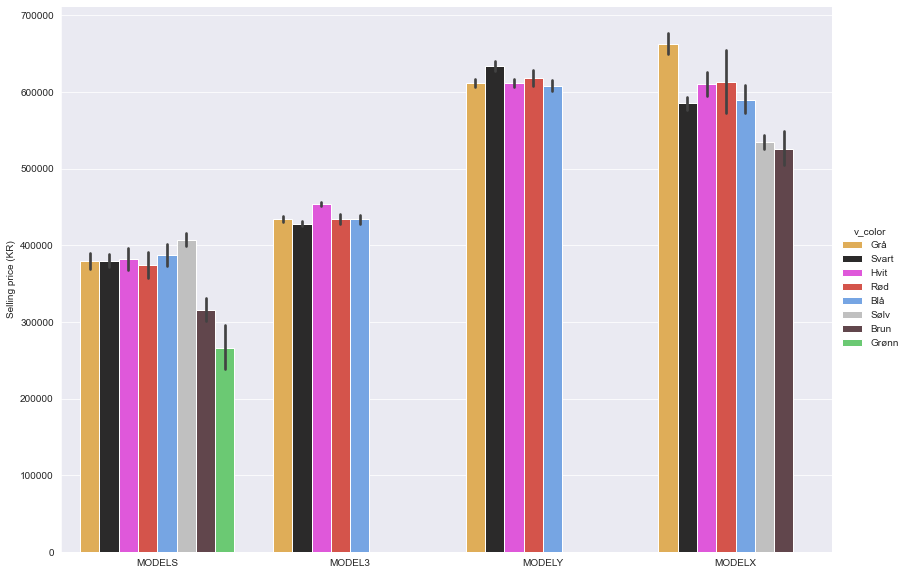

In [299]:
#White is pink and gray is orange to illustrate the differences
#Otherwise the colors match up
colors = {'Grå': "#f5b342",
          'Svart': "#2b2a2a",
          'Hvit': "#f542ef",
          'Rød': "#eb4034",
          'Blå':"#64a3f5",
          'Sølv':"#C0C0C0",
          'Brun':"#66414a",
          'Grønn':"#5bd966"

          }

cat_plot = sns.catplot(data=data,
                       kind='bar',
                       x='v_make',
                       y='price',
                       hue='v_color',
                       palette=colors,
                       height=8.27, aspect=11.7/8.2)
cat_plot.set_axis_labels('', 'Selling price (KR)')
plt.savefig('colors.png')

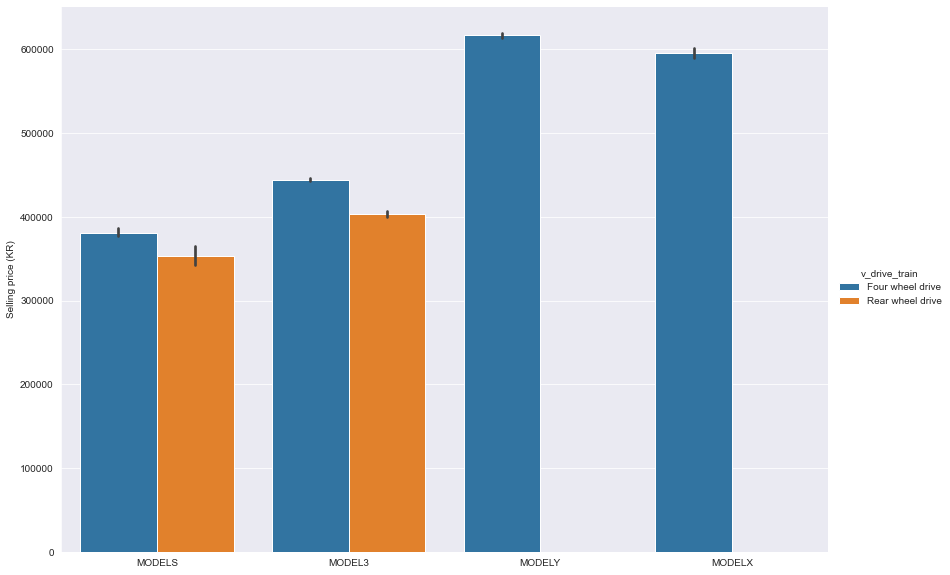

In [300]:
cat_plot = sns.catplot(data=data,
                       kind='bar',
                       x='v_make',
                       y='price',
                       hue='v_drive_train',
                       height=8.27, aspect=11.7/8.2)
cat_plot.set_axis_labels('', 'Selling price (KR)')

<AxesSubplot:xlabel='v_model_year_vim', ylabel='v_total_maximum_netto_effect'>

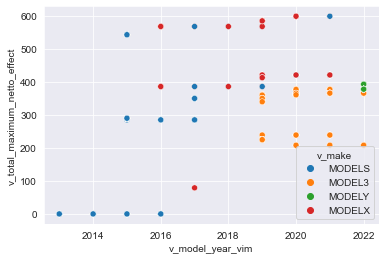

In [301]:

sns.scatterplot(data=data, x='v_model_year_vim', y = 'v_total_maximum_netto_effect', hue='v_make')
#Try to decode into modle specs Plad, 90D, -> Find it from v_max_speed?

<AxesSubplot:xlabel='sold_at_week_number'>

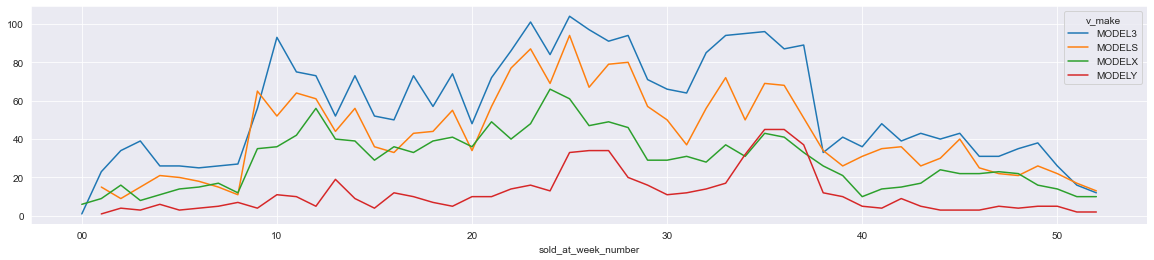

In [302]:
#Check for seasonality
seasonal_df = data.groupby(['sold_at_week_number', 'v_make'])['n'].sum().unstack()
seasonal_df.plot(figsize=(20,4))
#Conclude that data is seasonally dependent

In [303]:
data.head()

,created_at,sold_at,v_reg_nr,v_model_year_vim,v_make,sales_type,price,kilometers,v_width,v_length,...,v_import_country,v_fuel_type,retailer_count,v_el_range,days_befor_sale,sold_at_week_number,v_age,v_drive_train,v_total_maximum_netto_effect,n
0,2022-09-11,2022-09-15,EL45905,2015.0,MODELS,Privat,330009.0,133595.0,1964.0,4970.0,...,NORGE,Elektrisk,1.0,0.0,4,37,7.33,Four wheel drive,290.0,1
1,2022-09-10,2022-09-15,EV66503,2019.0,MODEL3,Privat,391670.0,42867.0,1850.0,4694.0,...,NORGE,Elektrisk,1.0,560.0,5,37,3.33,Four wheel drive,340.0,1
2,2022-09-07,2022-09-15,EV64926,2019.0,MODEL3,Forhandler,429000.0,55000.0,1850.0,4694.0,...,NORGE,Elektrisk,327.0,560.0,8,37,3.50,Four wheel drive,340.0,1
3,2022-09-10,2022-09-15,EV60868,2019.0,MODEL3,Privat,379670.0,74000.0,1850.0,4694.0,...,NORGE,Elektrisk,1.0,560.0,5,37,3.50,Four wheel drive,340.0,1
4,2022-08-28,2022-09-15,EV96977,2019.0,MODEL3,Privat,400670.0,94000.0,1850.0,4694.0,...,NORGE,Elektrisk,1.0,560.0,18,37,3.00,Four wheel drive,350.0,1


In [304]:
#Creating a new dataframe that drops a few redundant columns
#Remove created_at, sold_at and days,to sale since we would not know the latter
#also not sure how i would implement it
#will try to implement sold at week nr in a latter modle
mod_df = data.drop(['v_width',
                   'created_at',
                   'sold_at',
                    'sold_at_week_number',
                   'v_reg_nr',
                   'v_length',
                   'v_fuel_type',
                   'n',
                   'v_import_country']
                  , axis=1)

#mod_df['v_sold_at_dealership'] = mod_df['sales_type'].eq('Forhandler')
#mod_df = mod_df.drop(['sales_type'], axis=1)
mod_df.head()

,v_model_year_vim,v_make,sales_type,price,kilometers,v_color,v_maximum_speed,v_motor1_maximum_effect_per_hour,v_motor2_maximum_effect_per_hour,v_motor1_maximum_netto_effect,v_motor2_maximum_netto_effect,v_weight,v_allowed_total_weight,v_allowed_trailer_weight_without_breaks,retailer_count,v_el_range,days_befor_sale,v_age,v_drive_train,v_total_maximum_netto_effect
0,2015.0,MODELS,Privat,330009.0,133595.0,Grå,250.0,79.0,79.0,145.0,145.0,2175.0,2640.0,0.0,1.0,0.0,4,7.33,Four wheel drive,290.0
1,2019.0,MODEL3,Privat,391670.0,42867.0,Svart,233.0,65.0,88.0,150.0,190.0,1927.0,2305.0,0.0,1.0,560.0,5,3.33,Four wheel drive,340.0
2,2019.0,MODEL3,Forhandler,429000.0,55000.0,Hvit,233.0,65.0,88.0,150.0,190.0,1919.0,2305.0,0.0,327.0,560.0,8,3.50,Four wheel drive,340.0
3,2019.0,MODEL3,Privat,379670.0,74000.0,Rød,233.0,65.0,88.0,150.0,190.0,1926.0,2305.0,0.0,1.0,560.0,5,3.50,Four wheel drive,340.0
4,2019.0,MODEL3,Privat,400670.0,94000.0,Hvit,233.0,65.0,88.0,155.0,195.0,1857.0,2305.0,750.0,1.0,560.0,18,3.00,Four wheel drive,350.0


Categorical data left in the dataset is now:
- v_make
- v_color
- v_drive_train
- sales_type

In [305]:
#Make the categorical data into intagers -> Binary vector representation
#mod_df = pd.get_dummies(mod_df, drop_first=True)

dum_make = pd.get_dummies(mod_df.v_make)
dum_color = pd.get_dummies(mod_df.v_color)
dum_drive_train = pd.get_dummies(mod_df.v_drive_train)
dum_dealer = pd.get_dummies(mod_df.sales_type)

mod_df = pd.concat([mod_df, dum_make, dum_color,dum_drive_train, dum_dealer], axis=1)

mod_df = mod_df.drop(['v_make',
                      'v_color',
                      'v_drive_train',
                      'sales_type'], axis=1)

#dft_ms = mod_df.loc[data['v_make'] == 'MODELS']
#dft_m3 = mod_df.loc[data['v_make'] == 'MODEL3']
#dft_my = mod_df.loc[data['v_make'] == 'MODELY']
#dft_mx = mod_df.loc[data['v_make'] == 'MODELX']
mod_df.head()

,v_model_year_vim,price,kilometers,v_maximum_speed,v_motor1_maximum_effect_per_hour,v_motor2_maximum_effect_per_hour,v_motor1_maximum_netto_effect,v_motor2_maximum_netto_effect,v_weight,v_allowed_total_weight,...,Grønn,Hvit,Rød,Svart,Sølv,Four wheel drive,Rear wheel drive,Forhandler,Merkeforhandler,Privat
0,2015.0,330009.0,133595.0,250.0,79.0,79.0,145.0,145.0,2175.0,2640.0,...,0,0,0,0,0,1,0,0,0,1
1,2019.0,391670.0,42867.0,233.0,65.0,88.0,150.0,190.0,1927.0,2305.0,...,0,0,0,1,0,1,0,0,0,1
2,2019.0,429000.0,55000.0,233.0,65.0,88.0,150.0,190.0,1919.0,2305.0,...,0,1,0,0,0,1,0,1,0,0
3,2019.0,379670.0,74000.0,233.0,65.0,88.0,150.0,190.0,1926.0,2305.0,...,0,0,1,0,0,1,0,0,0,1
4,2019.0,400670.0,94000.0,233.0,65.0,88.0,155.0,195.0,1857.0,2305.0,...,0,1,0,0,0,1,0,0,0,1


In [306]:
mod_df.dtypes

v_model_year_vim                           float64
price                                      float64
kilometers                                 float64
v_maximum_speed                            float64
v_motor1_maximum_effect_per_hour           float64
v_motor2_maximum_effect_per_hour           float64
v_motor1_maximum_netto_effect              float64
v_motor2_maximum_netto_effect              float64
v_weight                                   float64
v_allowed_total_weight                     float64
v_allowed_trailer_weight_without_breaks    float64
retailer_count                             float64
v_el_range                                 float64
days_befor_sale                              int64
v_age                                      float64
v_total_maximum_netto_effect               float64
MODEL3                                       uint8
MODELS                                       uint8
MODELX                                       uint8
MODELY                         

<AxesSubplot:>

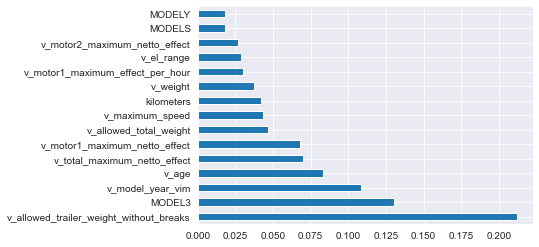

In [307]:
X = mod_df.drop('price', axis=1)
Y = mod_df['price']
mod = ExtraTreesRegressor()
mod.fit(X, Y)

feat_importances = pd.Series(mod.feature_importances_,index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [308]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
rf = RandomForestRegressor()


#Randomized Search CV


#Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(100, 1200, 12)]

#Number of features to consider at every split
max_features = ['auto', 'sqrt']

#Maximum number of levels in RandomForestRegressor
max_depth = [int(x) for x in np.linspace(5, 30, 6)]


#Minimum numbers of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]

#Minumum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

#Creating the random grid
random_grid = {'n_estimators':n_estimators,
               'max_features':max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

rf_random = RandomizedSearchCV(estimator= rf,
                               param_distributions = random_grid,
                               scoring = 'neg_mean_squared_error',
                               n_iter= 10,
                               cv = 5,
                               verbose=2,
                               random_state=42,
                               n_jobs= 1)
rf_random.fit(X_train, Y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   4.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   3.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

## Analizing the model

In [309]:
rf_random.best_params_


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [371]:
Y_pred = rf_random.predict(X_test)

d = {'Y_test': list(Y_test), 'Y_train': list(Y_train), 'Y_pred':list(Y_pred), 'Error': list(Y_test - Y_pred)}
result_df = pd.DataFrame({k:pd.Series(v) for k,v in d.items()})
result_df.describe()


,Y_test,Y_train,Y_pred,Error
count,1.848000e+03,5.541000e+03,1848.000000,1848.000000
mean,4.681731e+05,4.691962e+05,467681.192772,491.911665
std,1.268761e+05,1.258401e+05,122664.585587,25812.902797
min,1.890000e+05,1.800000e+05,217984.158000,-184514.998000
25%,3.907568e+05,3.950000e+05,396548.746000,-14556.370225
50%,4.516700e+05,4.499990e+05,452462.300800,193.519237
75%,5.441668e+05,5.399000e+05,537743.609125,14898.814746
max,1.015000e+06,1.050000e+06,970062.707000,134891.534320


Text(0.5, 1.0, 'Kernal Density Estimate')

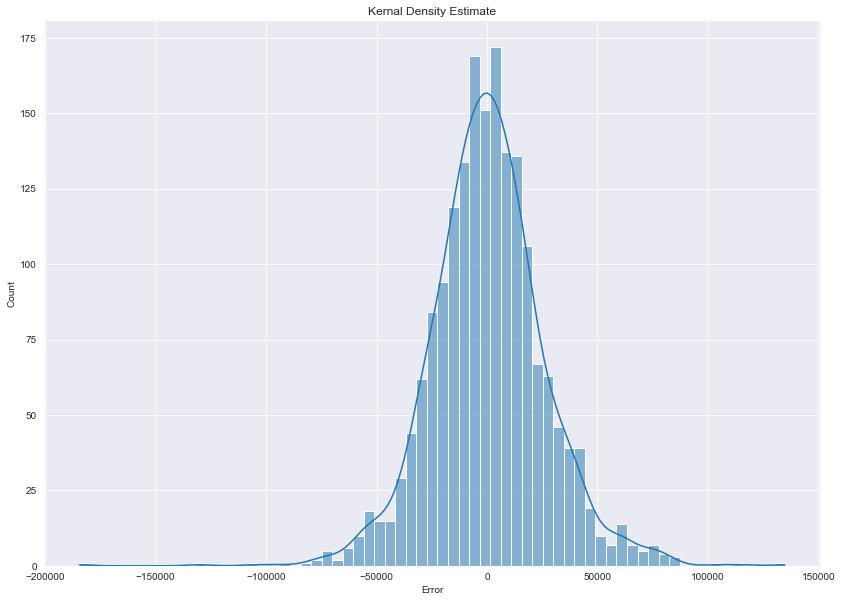

In [379]:
sns.displot(data = result_df, x='Error', kind="hist", kde=True, height=8.27, aspect=11.7/8.2)
plt.title("Kernal Density Estimate")

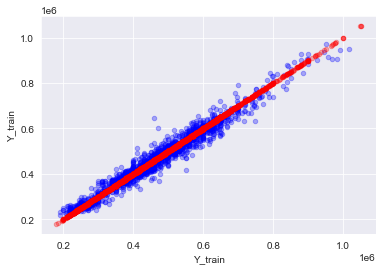

In [369]:

fig, ax = plt.subplots(1, 1)
result_df.plot.scatter('Y_test', 'Y_pred', color='blue', ax=ax, alpha=0.3)
result_df.plot.scatter('Y_train', 'Y_train', color='red', ax=ax, alpha=0.3)
plt.savefig('result train vs test.png')

<AxesSubplot:>

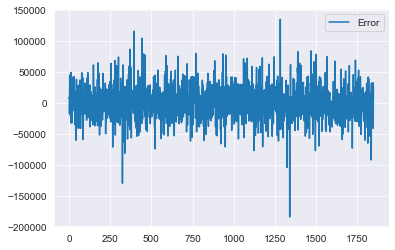

In [366]:


result_df.plot(y = 'Error')


In [350]:
print(f'*** Rundown of the Statistical Performance Indexes for this model ***\n\n'
      f'Mean Squared Error       [MSE]: {metrics.mean_squared_error(Y_test, Y_pred)}\n'
      f'Mean Absolute Error      [MAE]: {metrics.mean_absolute_error(Y_test, Y_pred)}\n'
      f'Root Mean Squared Error [RMSE]: {np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))}\n')


*** Rundown of the Statistical Performance Indexes for this model ***

Mean Squared Error       [MSE]: 666187372.7492994
Mean Absolute Error      [MAE]: 19248.539311750483
Root Mean Squared Error [RMSE]: 25810.605819106597



In [314]:

file = open('random_forest_regression_model.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)